In [15]:
import pandas as pd
from scipy.stats import ttest_ind, ttest_rel
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import statsmodels.api as sm
from copy import deepcopy

# columns for analysis. 
essential_cols = ['gender_recommendations', 
          'accuracy_vs_disparity', 
          'computers_vs_humans', 
          'black_boxes', 
          'compas_unfair']

# mapping from column names to full questions
pretty_titles = {'gender_recommendations':'Use gender in\ncourse recommendations\neven if it reduces\nwomen in science classes?', 
                 'accuracy_vs_disparity':'Reduce racial disparities\nin criminal risk prediction\nat expense of accuracy?', 
                 'computers_vs_humans':'Use computer algorithms\n(as opposed to human judges)\nin criminal justice at all?', 
                 'black_boxes':'Allow companies\nto keep details of\ncriminal justice\nalgorithms secret?', 
                 'compas_unfair':'Is the COMPAS\nalgorithm unfair?'}


# Read in data

Note: I do not include information about a respondent's profession in the released data because it makes the individual-level data too granular (ie, there are plenty of males and plenty of females but not too many females who study the humanities). Consequently, the cells at the very end of this notebook which analyze profession cannot be run, although I include them for completeness. If you would like this data, please shoot me an email at emmap1@cs.stanford.edu. 


## Computer science class data

In [16]:
# checked
pre_class_d = pd.read_csv('pre-class ethical dilemmas survey.csv')
post_class_d = pd.read_csv('post-class ethical dilemmas survey.csv')

print len(pre_class_d), 'pre-class responses'
print len(post_class_d), 'post-class responses'

pre_class_d.loc[pre_class_d['gender'].map(lambda x:x in ['Male', 'Female'])].groupby('gender').agg(['mean', 'size'])

87 pre-class responses
87 post-class responses


gender_recommendations      accuracy_vs_disparity       \
                         mean size                  mean size   
gender                                                          
Female               1.409091   22              5.272727   22   
Male                 2.061538   65              4.415385   65   

       computers_vs_humans      black_boxes      compas_unfair       
                      mean size        mean size          mean size  
gender                                                               
Female            2.818182   22    1.909091   22      5.500000   22  
Male              3.600000   65    2.246154   65      5.292308   65

In [17]:
post_class_d.loc[post_class_d['gender'].map(lambda x:x in ['Male', 'Female'])].groupby('gender').agg(['mean', 'size'])

gender_recommendations      accuracy_vs_disparity       \
                         mean size                  mean size   
gender                                                          
Female               1.590909   22              5.045455   22   
Male                 2.492308   65              4.384615   65   

       computers_vs_humans      black_boxes      compas_unfair       
                      mean size        mean size          mean size  
gender                                                               
Female            3.909091   22    1.272727   22      4.863636   22  
Male              4.569231   65    1.646154   65      5.215385   65

## Google consumer surveys data

In [18]:
# Checked. 
google_consumer_d = pd.read_csv('google_consumer_surveys_results.csv')
google_consumer_d.columns = ['timestamp', 
                             'publisher', 
                             'gender',
                             'age', 
                             'gender_recommendations', 
                             'targeted_gender_sample']
print '%i responses' % len(google_consumer_d)
google_consumer_d = google_consumer_d.loc[google_consumer_d['gender'].map(lambda x:x in ['Male', 'Female'])]
print google_consumer_d[['gender', 'gender_recommendations']].groupby('gender').agg(['mean', 'size'])
male_vals = google_consumer_d['gender_recommendations'].loc[google_consumer_d['gender'] == 'Male'].values
female_vals = google_consumer_d['gender_recommendations'].loc[google_consumer_d['gender'] == 'Female'].values

# note: the first 72 samples were collected without targeting for people whom Google could identify as 
# male or female. I then realized this meant we had to throw out a lot of data so switched to using 
# Google's gender targeting (so every sample was guaranteed to be identified as male or female). 
# The column targeted_gender_sample tells you whether the sample was collected using targeting. 
# Whether you include the 72 samples or not makes no significant difference to the effect size or the p-value. 
# I include them in the analysis.
# I use unweighted counts in computing statistics because Google Consumer Surveys does not provide weights for demographically targeted samples.


male_p = np.mean(male_vals >= 4)
female_p = np.mean(female_vals >= 4)
OR = ((male_p) / (1 - male_p)) / ((female_p) / (1 - female_p))
print 'Male vals of 4 or above: %2.3f; female vals: %2.3f; odds ratio %2.3f' % (male_p, female_p, OR)

573 responses
       gender_recommendations     
                         mean size
gender                            
Female               2.517730  282
Male                 3.010309  291
Male vals of 4 or above: 0.412; female vals: 0.287; odds ratio 1.741


## Social media data

In [19]:
# checked. 
social_media_d = pd.read_csv('social_media_survey_results.csv')
social_media_d.columns = ['gender_recommendations', 'accuracy_vs_disparity', 'computers_vs_humans', 'black_boxes', 'gender']
print 'Prior to dropping any missing data, %i rows' % len(social_media_d)
social_media_d = social_media_d.dropna(subset=[a for a in essential_cols if a in social_media_d.columns])
print 'After dropping missing data, %i rows' % len(social_media_d)


Prior to dropping any missing data, 163 rows
After dropping missing data, 163 rows


In [20]:
social_media_d.groupby('gender').agg({'mean', 'size'})

gender_recommendations      accuracy_vs_disparity       \
                         mean size                  mean size   
gender                                                          
Female               1.722222   72              5.013889   72   
Male                 2.868132   91              3.945055   91   

       computers_vs_humans      black_boxes       
                      mean size        mean size  
gender                                            
Female            3.666667   72    2.375000   72  
Male              4.219780   91    2.373626   91

# Combined gender results

Social Media         gender_recommendations    question: male_mu: 2.868; female_mu 1.722; diff 1.146; p 3.256e-05
GCS                  gender_recommendations    question: male_mu: 3.010; female_mu 2.518; diff 0.493; p 3.526e-03
Pre-class            gender_recommendations    question: male_mu: 2.062; female_mu 1.409; diff 0.652; p 2.429e-02
Post-class           gender_recommendations    question: male_mu: 2.492; female_mu 1.591; diff 0.901; p 1.757e-02
Social Media         accuracy_vs_disparity     question: male_mu: 3.945; female_mu 5.014; diff -1.069; p 4.197e-04
Pre-class            accuracy_vs_disparity     question: male_mu: 4.415; female_mu 5.273; diff -0.857; p 4.252e-02
Post-class           accuracy_vs_disparity     question: male_mu: 4.385; female_mu 5.045; diff -0.661; p 1.148e-01
Social Media         computers_vs_humans       question: male_mu: 4.220; female_mu 3.667; diff 0.553; p 5.584e-02
Pre-class            computers_vs_humans       question: male_mu: 3.600; female_mu 2.

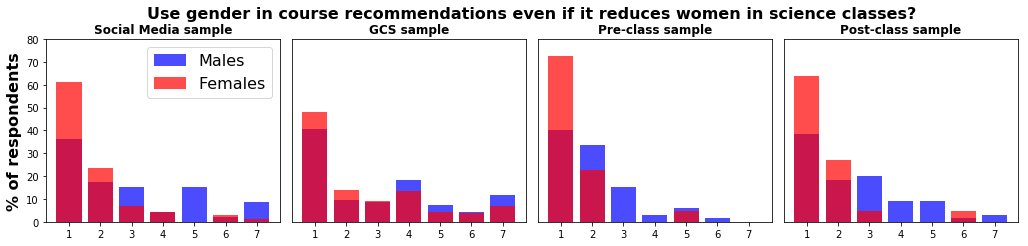

In [21]:
# Checked.  

def get_star_for_significance(p):
    if p < .001:
        return '***'
    if p < .01:
        return '**'
    if p < .05:
        return '*'
    return ''

results_df = []
plt.figure(figsize=[15, 3.5])
sample_names = ['Social Media', 'GCS', 'Pre-class', 'Post-class']
for k in ['gender_recommendations', u'accuracy_vs_disparity',
       u'computers_vs_humans', u'black_boxes', u'compas_unfair']:
    results_for_question = {'question':k}
    for sample_idx, d in enumerate([social_media_d, google_consumer_d, pre_class_d, post_class_d]):
        if k not in d.columns:
            results_string = '-'
        else:
            
            male_vals = d.loc[d['gender'] == 'Male', k]
            female_vals = d.loc[d['gender'] == 'Female', k]
            male_mu = male_vals.mean()
            female_mu = female_vals.mean()
            t, p = ttest_ind(male_vals, female_vals)
            print '%-20s %-25s question: male_mu: %2.3f; female_mu %2.3f; diff %2.3f; p %2.3e' % (sample_names[sample_idx],
                                                                                            k, 
                                                                                            male_mu, 
                                                                                            female_mu, 
                                                                                            male_mu - female_mu, 
                                                                                            p)
            p_star = get_star_for_significance(p)
            results_string = '%2.1f,%2.1f%s p=%2.1e' % (male_vals.mean(), 
                                                            female_vals.mean(), 
                                                            p_star, 
                                                            p)
            if k == 'gender_recommendations':
                plt.subplot(1, 4, sample_idx + 1)
                possible_answers = range(1, 8)
                male_counts = Counter(male_vals)
                female_counts = Counter(female_vals)
                male_bars = [100.0 * male_counts[i] / len(male_vals) for i in possible_answers]
                female_bars = [100.0 * female_counts[i] / len(female_vals) for i in possible_answers]
                plt.bar(possible_answers, male_bars, color = 'blue', alpha = .7, label = 'Males')
                plt.bar(possible_answers, female_bars, color = 'red', alpha = .7, label = 'Females')
                
                
                if sample_idx == 0:
                    plt.ylabel("% of respondents", fontsize = 16, fontweight = 'bold')
                else:
                    plt.yticks([])
                if sample_idx == 0:
                    plt.legend(fontsize = 16)
                plt.title(sample_names[sample_idx] + ' sample', fontweight='bold')
                plt.ylim([0, 80])
                plt.xticks(possible_answers, possible_answers)
                
        results_for_question[sample_names[sample_idx]] = results_string
    results_df.append(results_for_question)
results_df = pd.DataFrame(results_df)
results_df.index = results_df['question']
results_df.index = results_df.index.map(lambda x:pretty_titles[x].replace('\n', ' '))
results_df = results_df[['Social Media', 'GCS', 'Pre-class', 'Post-class']]
plt.subplots_adjust(wspace=.05, top=.85, left=.05, right=.95)
plt.suptitle('Use gender in course recommendations even if it reduces women in science classes?', 
             fontsize=16,
             fontweight='bold')
plt.savefig('gender_summary_plot.pdf')
plt.show()
    
    

In [22]:
results_df

,Social Media,GCS,Pre-class,Post-class
Use gender in course recommendations even if it reduces women in science classes?,"2.9,1.7*** p=3.3e-05","3.0,2.5** p=3.5e-03","2.1,1.4* p=2.4e-02","2.5,1.6* p=1.8e-02"
Reduce racial disparities in criminal risk prediction at expense of accuracy?,"3.9,5.0*** p=4.2e-04",-,"4.4,5.3* p=4.3e-02","4.4,5.0 p=1.1e-01"
Use computer algorithms (as opposed to human judges) in criminal justice at all?,"4.2,3.7 p=5.6e-02",-,"3.6,2.8 p=5.4e-02","4.6,3.9 p=7.1e-02"
Allow companies to keep details of criminal justice algorithms secret?,"2.4,2.4 p=1.0e+00",-,"2.2,1.9 p=3.3e-01","1.6,1.3 p=1.1e-01"
Is the COMPAS algorithm unfair?,-,-,"5.3,5.5 p=4.8e-01","5.2,4.9 p=2.7e-01"


In [23]:
pd.set_option('max_colwidth', 500)
print results_df.to_latex()

\begin{tabular}{lllll}
\toprule
{} &          Social Media &                  GCS &           Pre-class &          Post-class \\
\midrule
Use gender in course recommendations even if it reduces women in science classes? &  2.9,1.7*** p=3.3e-05 &  3.0,2.5** p=3.5e-03 &  2.1,1.4* p=2.4e-02 &  2.5,1.6* p=1.8e-02 \\
Reduce racial disparities in criminal risk prediction at expense of accuracy?     &  3.9,5.0*** p=4.2e-04 &                    - &  4.4,5.3* p=4.3e-02 &   4.4,5.0 p=1.1e-01 \\
Use computer algorithms (as opposed to human judges) in criminal justice at all?  &     4.2,3.7 p=5.6e-02 &                    - &   3.6,2.8 p=5.4e-02 &   4.6,3.9 p=7.1e-02 \\
Allow companies to keep details of criminal justice algorithms secret?            &     2.4,2.4 p=1.0e+00 &                    - &   2.2,1.9 p=3.3e-01 &   1.6,1.3 p=1.1e-01 \\
Is the COMPAS algorithm unfair?                                                   &                     - &                    - &   5.3,5.5 p=4.8e-01 &   5.2

# Longitudinal analysis

gender_recommendations: mu_pre = 1.90, mu_post = 2.26, std_pre = 1.17, std_post = 1.54
accuracy_vs_disparity: mu_pre = 4.63, mu_post = 4.55, std_pre = 1.71, std_post = 1.69
computers_vs_humans: mu_pre = 3.40, mu_post = 4.40, std_pre = 1.64, std_post = 1.47
black_boxes: mu_pre = 2.16, mu_post = 1.55, std_pre = 1.38, std_post = 0.93
compas_unfair: mu_pre = 5.34, mu_post = 5.13, std_pre = 1.17, std_post = 1.28


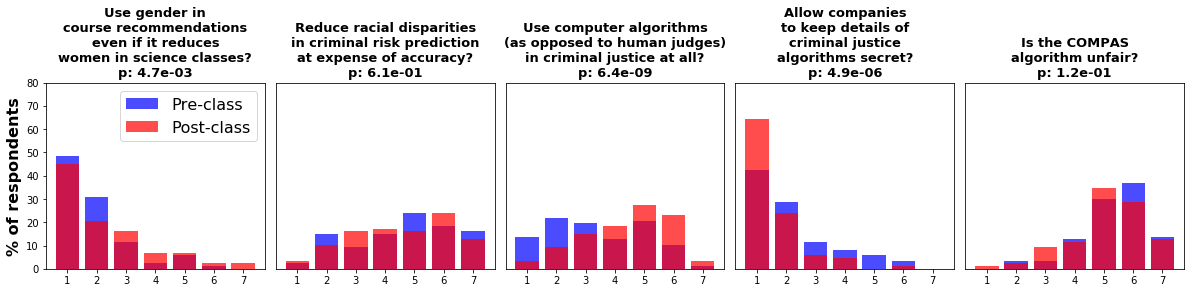

In [24]:
plt.figure(figsize=[17, 4.5])
for plt_idx, k in enumerate(['gender_recommendations', 
          'accuracy_vs_disparity', 
          'computers_vs_humans', 
          'black_boxes', 
          'compas_unfair']):
    
    pre_ids_to_values = dict(zip(pre_class_d['id'], 
                                 pre_class_d[k]))
    post_ids_to_values = dict(zip(post_class_d['id'], 
                                 post_class_d[k]))
    assert sorted(pre_ids_to_values.keys()) == sorted(post_ids_to_values.keys()) 
    good_ids = sorted(pre_ids_to_values.keys())
    
    paired_pre_vals = np.array([pre_ids_to_values[a] for a in good_ids])
    paired_post_vals = np.array([post_ids_to_values[a] for a in good_ids])
    
    t, p = ttest_rel(paired_pre_vals, paired_post_vals)
    plt.subplot(1, 5, plt_idx + 1)
    possible_answers = range(1, 8)
    pre_counts = Counter(paired_pre_vals)
    post_counts = Counter(paired_post_vals)
    pre_bars = [100.0 * pre_counts[i] / len(paired_pre_vals) for i in possible_answers]
    post_bars = [100.0 * post_counts[i] / len(paired_post_vals) for i in possible_answers]
    
    print '%s: mu_pre = %2.2f, mu_post = %2.2f, std_pre = %2.2f, std_post = %2.2f' % (k, 
                                                                                     np.mean(paired_pre_vals), 
                                                                                      np.mean(paired_post_vals), 
                                                                                      np.std(paired_pre_vals), 
                                                                                      np.std(paired_post_vals))
    plt.bar(possible_answers, pre_bars, color = 'blue', alpha = .7, label = 'Pre-class')
    plt.bar(possible_answers, post_bars, color = 'red', alpha = .7, label = 'Post-class')

    if plt_idx == 0:
        plt.ylabel("% of respondents", fontsize = 16, fontweight = 'bold')
        plt.legend(fontsize = 16)
    else:
        plt.yticks([])
        
    plt.title(pretty_titles[k] + '\np: %2.1e' % p, fontsize=13, fontweight='bold')
    plt.ylim([0, 80])
    plt.xticks(possible_answers, possible_answers)
plt.subplots_adjust(wspace=.05, top=.7, left=.05, right=.98)
plt.savefig('pre_post_summary_plot.pdf')
plt.show()

    
    
    
    

    


## did your opinion change? 

In [25]:
print Counter(post_class_d['changed_opinion'])
print 1.0*post_class_d[['changed_opinion']].groupby('changed_opinion').size() / len(post_class_d)

Counter({'At least one of my opinions has slightly changed': 64, 'At least one of my opinions has significantly changed': 15, 'All my opinions are exactly the same as they were before': 7, 'At least one of my opinions has totally changed': 1})
changed_opinion
All my opinions are exactly the same as they were before    0.080460
At least one of my opinions has significantly changed       0.172414
At least one of my opinions has slightly changed            0.735632
At least one of my opinions has totally changed             0.011494
dtype: float64


# Miscellaneous robustness checks

#### Is there an overall significant association between gender and answers to questions? Yes. Flip the regression around to test for associations with all questions simultaneously. 


In [26]:
# checked. 
surveys = ['pre_class', 'post_class', 'social media']

for d_idx, d in enumerate([pre_class_d, post_class_d, social_media_d]):
    print '******%s' % surveys[d_idx]    
    d['gender_female'] = 1.*(d['gender'] == 'Female')
    if surveys[d_idx] == 'social media':
        model = sm.Logit.from_formula("gender_female ~ gender_recommendations + accuracy_vs_disparity + computers_vs_humans + black_boxes", 
                                      data = d).fit()
    else:
        model = sm.Logit.from_formula("gender_female ~ compas_unfair + gender_recommendations + accuracy_vs_disparity + computers_vs_humans + black_boxes", 
                                      data = d).fit()
    print 'Association between all questions and gender in %s: %2.3e' % (surveys[d_idx], 
                                                                         model.llr_pvalue)
        
    

******pre_class
Optimization terminated successfully.
         Current function value: 0.501491
         Iterations 6
Association between all questions and gender in pre_class: 4.882e-02
******post_class
Optimization terminated successfully.
         Current function value: 0.467756
         Iterations 7
Association between all questions and gender in post_class: 4.496e-03
******social media
Optimization terminated successfully.
         Current function value: 0.613444
         Iterations 6
Association between all questions and gender in social media: 8.908e-05


## Robustness checks: does adding in profession change the associations with gender? 

As noted above, this code cannot actually be run using the released data but we include it for completeness. 

In [14]:
raise Exception("Code below here cannot be run because profession data has been redacted for privacy.")

In [13]:
print 'Computer science class field counts'
print Counter(pre_class_d['profession'])

print 'Social media survey field counts'
print Counter(social_media_d['profession'])





Computer science class field counts
Counter({'Computer scientist': 61, 'Other mathematical / scientific field': 23, 'Other humanities field': 3})
Social media survey field counts
Counter({'Other humanities field': 77, 'Computer scientist': 49, 'Other mathematical / scientific field': 37})


#### Is there any significant association between profession and answers to questions? Not really. Of course, sample is small, so there might be meaningful effects we can't detect, but no compelling evidence. (In the post-class sample there is one p-value below .05, but this doesn't hold up to slightly changing the specification of the model, and in any case we're running like a million tests.)

In [14]:
# Checked. 
surveys = ['pre_class', 'post_class', 'social media']

for d_idx, d in enumerate([pre_class_d, post_class_d, social_media_d]):
    cols_to_examine = [a for a in essential_cols if a in d.columns]
    print '******%s' % surveys[d_idx]
    print Counter(d['profession'])
    d['profession_computer_science'] = (d['profession'] == 'Computer scientist') * 1.0
    d['profession_humanities'] = (d['profession'] == 'Other humanities field') * 1.0
    rhs = '+'.join(cols_to_examine)
    if d['profession_humanities'].sum() > 10:
        model = sm.Logit.from_formula("profession_humanities ~ %s" % rhs, data = d).fit()
        print model.summary()

    model = sm.Logit.from_formula("profession_computer_science ~ %s" % rhs, data = d).fit()
    print model.summary()

    for col in cols_to_examine:
        model = sm.OLS.from_formula('%s ~ profession' % col, data = d).fit()
        print 'significance of association between profession and %s: %2.5f' % (col, model.f_pvalue)

******pre_class
Counter({'Computer scientist': 61, 'Other mathematical / scientific field': 23, 'Other humanities field': 3})
Optimization terminated successfully.
         Current function value: 0.580478
         Iterations 6
                                Logit Regression Results                               
Dep. Variable:     profession_computer_science   No. Observations:                   87
Model:                                   Logit   Df Residuals:                       81
Method:                                    MLE   Df Model:                            5
Date:                         Sat, 03 Mar 2018   Pseudo R-squ.:                 0.04822
Time:                                 20:32:15   Log-Likelihood:                -50.502
converged:                                True   LL-Null:                       -53.060
                                                 LLR p-value:                    0.4017
                             coef    std err          z      P>|z|  

#### Is there an association between gender and profession? Yes, some association. 

In [15]:
# Checked. 
surveys = ['pre_class', 'post_class', 'social media']

for d_idx, d in enumerate([pre_class_d, post_class_d, social_media_d]):
    print '******%s' % surveys[d_idx]
    model = sm.Logit.from_formula('gender_female ~ profession', data = d).fit()
    print 'significance of association between female and profession %2.3f' % model.llr_pvalue

    print d[['profession', 'gender_female']].groupby('profession').agg(['mean', 'size'])

******pre_class
Optimization terminated successfully.
         Current function value: 0.562100
         Iterations 5
significance of association between female and profession 0.746
                                      gender_female     
                                               mean size
profession                                              
Computer scientist                         0.229508   61
Other humanities field                     0.333333    3
Other mathematical / scientific field      0.304348   23
******post_class
Optimization terminated successfully.
         Current function value: 0.562100
         Iterations 5
significance of association between female and profession 0.746
                                      gender_female     
                                               mean size
profession                                              
Computer scientist                         0.229508   61
Other humanities field                     0.333333    3
Other ma

#### Do the associations between algorithmic fairness beliefs and gender remain significant when we control for profession? Yes. 

In [16]:
# Checked. 

surveys = ['pre_class', 'post_class', 'social media']
all_results = []
for d_idx, d in enumerate([pre_class_d, post_class_d, social_media_d]):
    cols_to_examine = [a for a in essential_cols if a in d.columns]
    for col in cols_to_examine:
        model_without_profession = sm.OLS.from_formula('%s ~ gender' % col, data = d).fit()
        model_with_profession = sm.OLS.from_formula('%s ~ gender + profession' % col, data = d).fit()
        all_results.append({'population':surveys[d_idx], 
                            'question':col, 
                             'beta_without_profession':model_without_profession.params['gender[T.Male]'],
                             'beta_with_profession':model_with_profession.params['gender[T.Male]'],
                            'pvalue_without_profession':model_without_profession.pvalues['gender[T.Male]'], 
                             'pvalue_with_profession':model_with_profession.pvalues['gender[T.Male]']})
all_results = pd.DataFrame(all_results)
all_results[['population', 
             'question', 
             'beta_without_profession', 
             'beta_with_profession', 
             'pvalue_without_profession', 
             'pvalue_with_profession']]
    






,population,question,beta_without_profession,beta_with_profession,pvalue_without_profession,pvalue_with_profession
0,pre_class,gender_recommendations,0.652448,0.618698,0.024291,0.032458
1,pre_class,accuracy_vs_disparity,-0.857343,-0.845307,0.042520,0.043012
2,pre_class,computers_vs_humans,0.781818,0.807711,0.053574,0.048755
3,pre_class,black_boxes,0.337063,0.288309,0.327829,0.401041
4,pre_class,compas_unfair,-0.207692,-0.199130,0.478533,0.497872
5,post_class,gender_recommendations,0.901399,0.860256,0.017574,0.023278
6,post_class,accuracy_vs_disparity,-0.660839,-0.676904,0.114802,0.092715
7,post_class,computers_vs_humans,0.660140,0.682668,0.070719,0.057936
8,post_class,black_boxes,0.373427,0.348582,0.106559,0.133133
9,post_class,compas_unfair,0.351748,0.351915,0.272285,0.263363
